# Quantitative Trading & Portfolio Analysis (Airbus)

This notebook:
- downloads historical prices with `yfinance`,
- computes technical indicators (moving averages, RSI),
- backtests a simple RSI strategy,
- analyzes a multi-asset portfolio and performs Sharpe-ratio optimization,
- saves all plots into `figures/` so they can be included in the LaTeX report.

If needed, install dependencies:

```bash
pip install yfinance pandas numpy matplotlib scipy openpyxl
```

In [26]:
# Imports
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.optimize import minimize

# Reproducibility for any random sampling (if used later)
np.random.seed(42)

# Output folder for report figures
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

## 1) Airbus stock analysis (AIR.PA)

In [27]:
def download_stock_data(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
    """Download stock data from Yahoo Finance using yfinance."""
    df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False, progress=False)
    return df

def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    """Basic cleaning: drop missing rows and ensure datetime index."""
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.dropna(how="any")
    return df

# Parameters (edit if you want a different range)
SYMBOL = "AIR.PA"     # Airbus SE (Euronext Paris)
START_DATE = "2014-01-01"
END_DATE   = "2024-01-01"

stock_raw = download_stock_data(SYMBOL, START_DATE, END_DATE)
stock = clean_stock_data(stock_raw)

stock.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AIR.PA,AIR.PA,AIR.PA,AIR.PA,AIR.PA,AIR.PA
Date,,,,,,
2014-01-02,47.453815,56.549999,56.849998,55.680000,56.040001,1875512
2014-01-03,47.327942,56.400002,56.900002,56.290001,56.790001,1333141
2014-01-06,46.513973,55.430000,56.549999,55.400002,56.549999,1664844
2014-01-07,46.916763,55.910000,55.959999,55.020000,55.900002,1950728
2014-01-08,46.446835,55.349998,56.099998,54.919998,56.000000,1837218


In [29]:
# Save the cleaned data to Excel (optional, useful for appendix)
output_excel = os.path.join(FIG_DIR, "airbus_stock_data.xlsx")
stock.to_excel(output_excel, engine="openpyxl")
output_excel

'figures/airbus_stock_data.xlsx'

### 1.1 Moving Averages (MA5 / MA20)

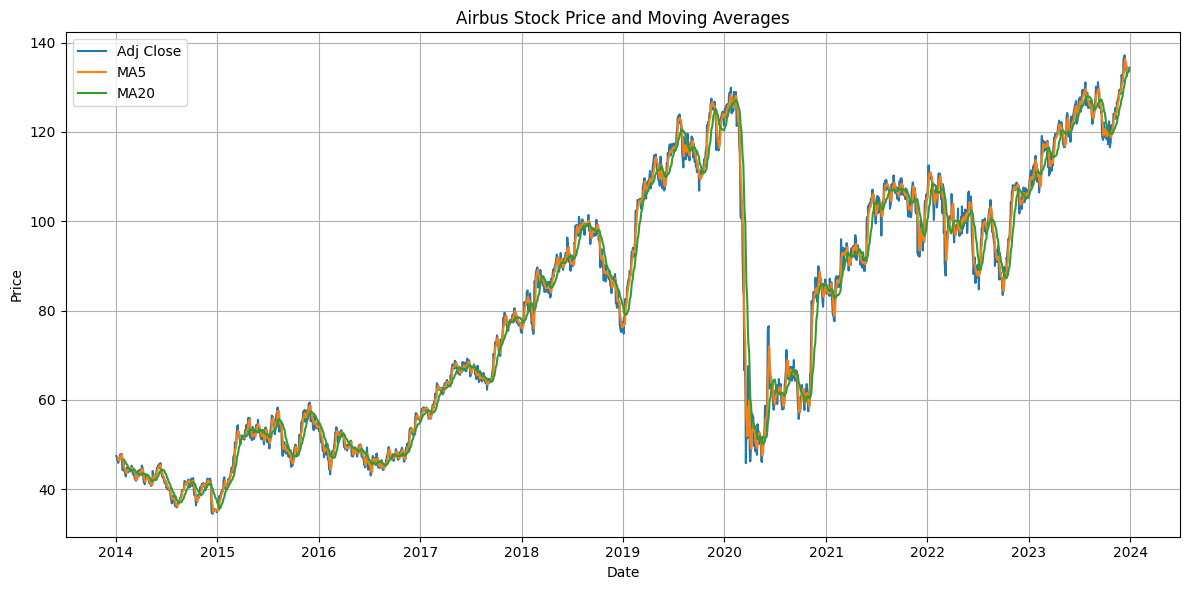

'figures/airbus_moving_average.png'

In [30]:
# Compute moving averages on Adjusted Close
stock["MA5"] = stock["Adj Close"].rolling(window=5).mean()
stock["MA20"] = stock["Adj Close"].rolling(window=20).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(stock.index, stock["Adj Close"], label="Adj Close")
plt.plot(stock.index, stock["MA5"], label="MA5")
plt.plot(stock.index, stock["MA20"], label="MA20")
plt.title("Airbus Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

fig_path_ma = os.path.join(FIG_DIR, "airbus_moving_average.png")
plt.tight_layout()
plt.savefig(fig_path_ma, dpi=300)
plt.show()

fig_path_ma

### 1.2 Relative Strength Index (RSI-14)

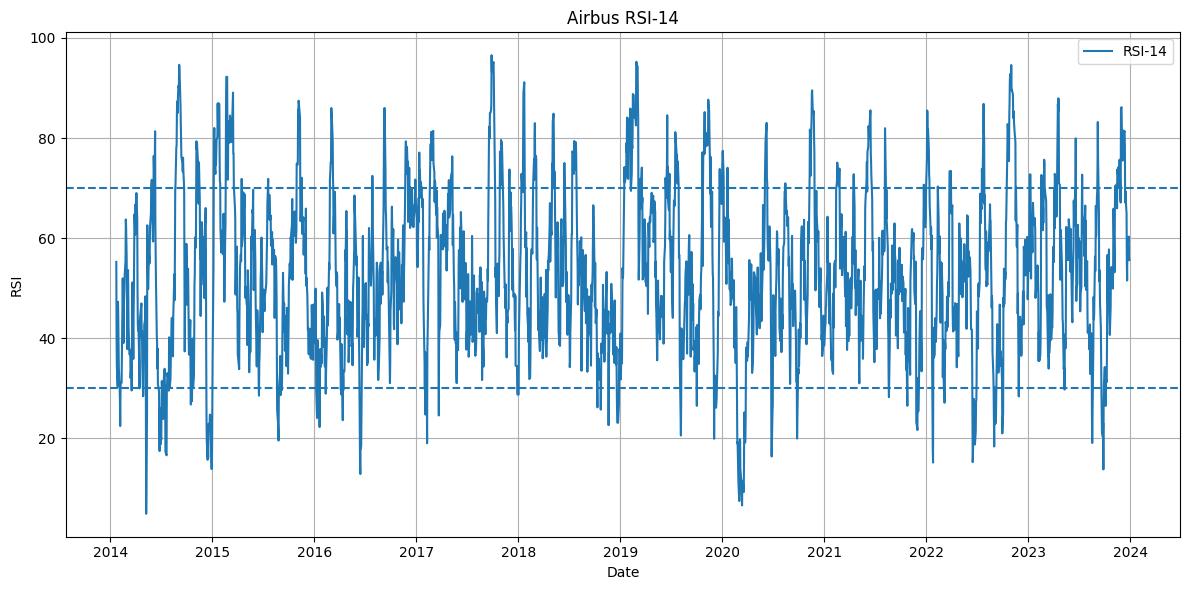

'figures/airbus_rsi.png'

In [31]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """Compute the Relative Strength Index (RSI) for a price series."""
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock["RSI14"] = compute_rsi(stock["Adj Close"], period=14)

plt.figure(figsize=(12, 6))
plt.plot(stock.index, stock["RSI14"], label="RSI-14")
plt.axhline(70, linestyle="--")
plt.axhline(30, linestyle="--")
plt.title("Airbus RSI-14")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)

fig_path_rsi = os.path.join(FIG_DIR, "airbus_rsi.png")
plt.tight_layout()
plt.savefig(fig_path_rsi, dpi=300)
plt.show()

fig_path_rsi

### 1.3 Simple RSI Strategy Backtest

In [44]:
import numpy as np
import pandas as pd

def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def backtest_rsi_strategy(df: pd.DataFrame,
                          rsi_col: str = "RSI14",
                          price_col: str = "Adj Close",
                          buy_threshold: float = 30,
                          sell_threshold: float = 70,
                          initial_capital: float = 10_000.0,
                          trade_cash: float = 1_000.0) -> pd.DataFrame:
    """Simple discrete strategy (fees/taxes ignored, fractional shares allowed)."""

    df = df.copy()

    # 1) Flatten MultiIndex columns if any (common with yfinance multiple tickers)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # 2) Ensure we have a price column under the requested name
    if price_col not in df.columns:
        if "Close" in df.columns:
            df[price_col] = df["Close"]          # fallback
        else:
            raise KeyError(f"No usable price column. Available columns: {list(df.columns)}")

    # 3) Ensure RSI exists
    if rsi_col not in df.columns:
        df[rsi_col] = compute_rsi(df[price_col], 14)

    # 4) Clean rows
    df = df.dropna(subset=[rsi_col, price_col])

    cash = initial_capital
    shares = 0.0
    portfolio_values = []
    actions = []

    for _, row in df.iterrows():
        price = float(row[price_col])
        rsi = float(row[rsi_col])

        action = "HOLD"
        if rsi < buy_threshold:
            amount = min(trade_cash, cash)
            if amount > 0:
                shares += amount / price
                cash -= amount
                action = "BUY"
        elif rsi > sell_threshold:
            shares_to_sell = min(trade_cash / price, shares)
            if shares_to_sell > 0:
                cash += shares_to_sell * price
                shares -= shares_to_sell
                action = "SELL"

        portfolio_values.append(cash + shares * price)
        actions.append(action)

    out = df.copy()
    out["Action"] = actions
    out["PortfolioValue"] = portfolio_values
    return out

bt = backtest_rsi_strategy(stock,
                           buy_threshold=30,
                           sell_threshold=70,
                           initial_capital=10_000.0,
                           trade_cash=1_000.0)

bt[["Adj Close", "RSI14", "Action", "PortfolioValue"]].head()

Price,Adj Close,RSI14,Action,PortfolioValue
Date,,,,
2014-01-22,47.915352,55.238186,HOLD,10000.0
2014-01-23,46.069218,39.725974,HOLD,10000.0
2014-01-24,44.290230,34.319469,HOLD,10000.0
2014-01-27,44.273449,30.287805,HOLD,10000.0
2014-01-28,46.010475,47.263129,HOLD,10000.0


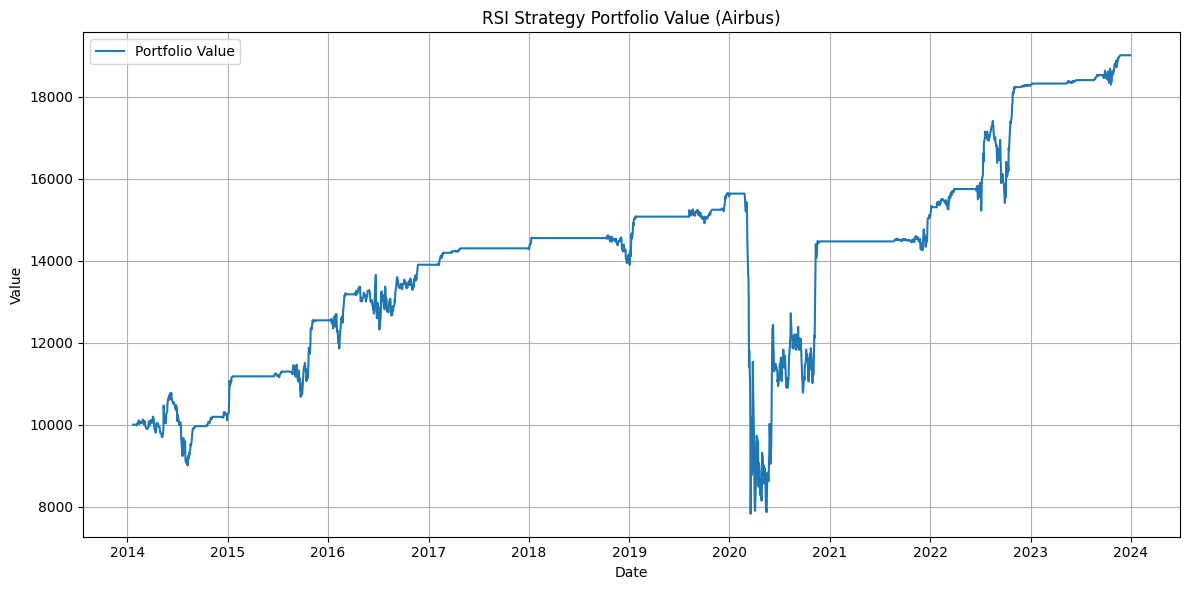

'figures/airbus_rsi_strategy_portfolio_value.png'

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(bt.index, bt["PortfolioValue"], label="Portfolio Value")
plt.title("RSI Strategy Portfolio Value (Airbus)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

fig_path_bt = os.path.join(FIG_DIR, "airbus_rsi_strategy_portfolio_value.png")
plt.tight_layout()
plt.savefig(fig_path_bt, dpi=300)
plt.show()

fig_path_bt

## 2) Portfolio analysis & optimization (including Airbus)

In [34]:
# Choose a small multi-asset portfolio (edit as you wish)
# - AIR.PA : Airbus (Europe)
# - BA     : Boeing (US)
# - SAF.PA : Safran (Europe)
# - GLD    : Gold ETF (US)
PORTFOLIO_TICKERS = ["AIR.PA", "BA", "SAF.PA", "GLD"]

portfolio_raw = yf.download(PORTFOLIO_TICKERS, start=START_DATE, end=END_DATE, auto_adjust=False, progress=False)

# Use adjusted close
adj_close = portfolio_raw["Adj Close"].dropna(how="any")
adj_close.head()

Ticker,AIR.PA,BA,GLD,SAF.PA
Date,,,,
2014-01-02,47.453815,116.807968,118.000000,43.403217
2014-01-03,47.327942,117.619873,119.290001,44.188595
2014-01-06,46.513973,118.295074,119.500000,44.525185
2014-01-07,46.916763,120.089882,118.820000,44.326683
2014-01-08,46.446835,120.354813,118.120003,44.128181


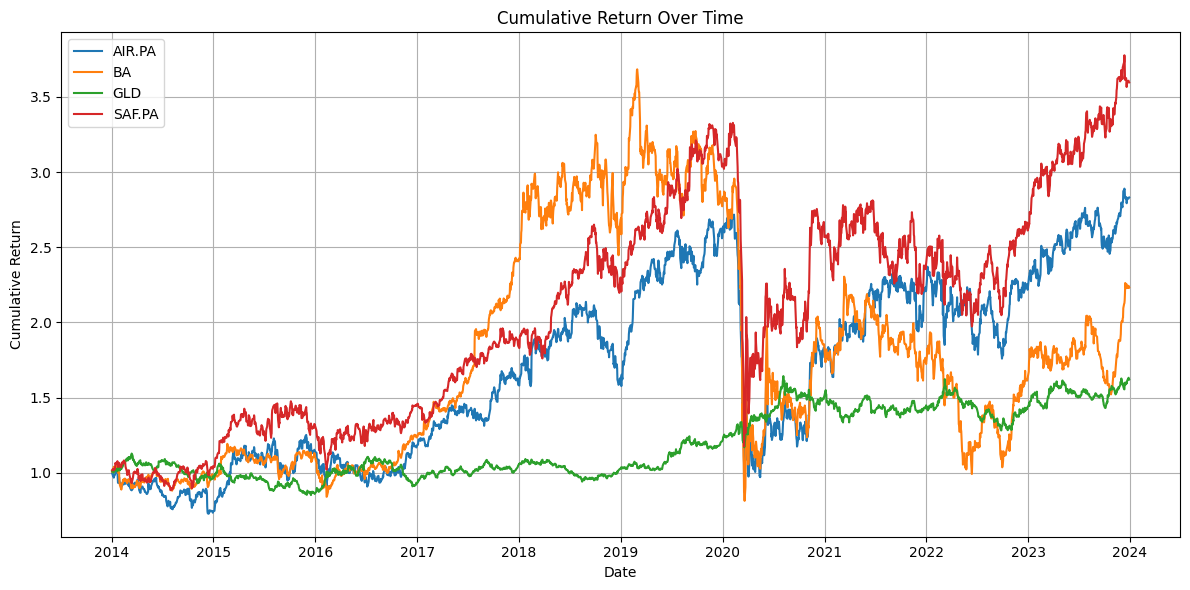

'figures/portfolio_cumulative_returns.png'

In [35]:
returns = adj_close.pct_change().dropna()
cum_returns = (1 + returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_returns.index, cum_returns)
plt.title("Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(cum_returns.columns)
plt.grid(True)

fig_path_cum = os.path.join(FIG_DIR, "portfolio_cumulative_returns.png")
plt.tight_layout()
plt.savefig(fig_path_cum, dpi=300)
plt.show()

fig_path_cum

In [36]:
# Annualized return and volatility (assuming 252 trading days)
ann_return = returns.mean() * 252
ann_vol = returns.std() * np.sqrt(252)

metrics = pd.DataFrame({
    "AnnualizedReturn": ann_return,
    "AnnualizedVolatility": ann_vol
}).sort_index()

metrics

,AnnualizedReturn,AnnualizedVolatility
Ticker,,
AIR.PA,0.169164,0.357582
BA,0.159221,0.394860
GLD,0.058773,0.141431
SAF.PA,0.184772,0.332404


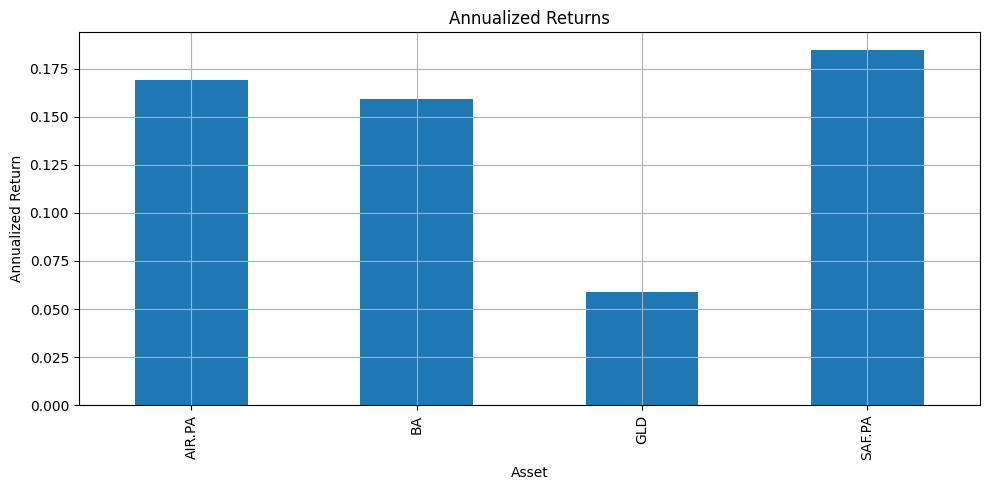

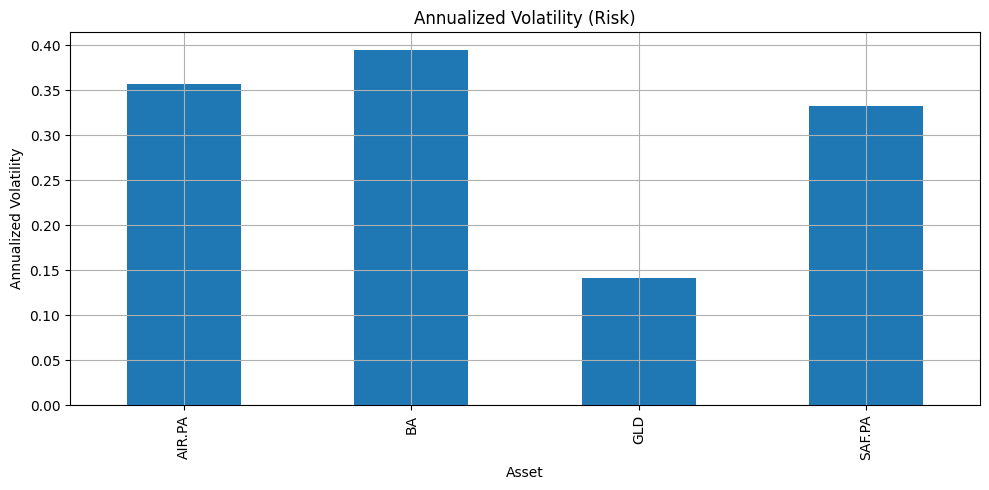

('figures/portfolio_annualized_returns.png',
 'figures/portfolio_annualized_volatility.png')

In [37]:
plt.figure(figsize=(10, 5))
metrics["AnnualizedReturn"].plot(kind="bar")
plt.title("Annualized Returns")
plt.xlabel("Asset")
plt.ylabel("Annualized Return")
plt.grid(True)

fig_path_ann_ret = os.path.join(FIG_DIR, "portfolio_annualized_returns.png")
plt.tight_layout()
plt.savefig(fig_path_ann_ret, dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
metrics["AnnualizedVolatility"].plot(kind="bar")
plt.title("Annualized Volatility (Risk)")
plt.xlabel("Asset")
plt.ylabel("Annualized Volatility")
plt.grid(True)

fig_path_ann_vol = os.path.join(FIG_DIR, "portfolio_annualized_volatility.png")
plt.tight_layout()
plt.savefig(fig_path_ann_vol, dpi=300)
plt.show()

(fig_path_ann_ret, fig_path_ann_vol)

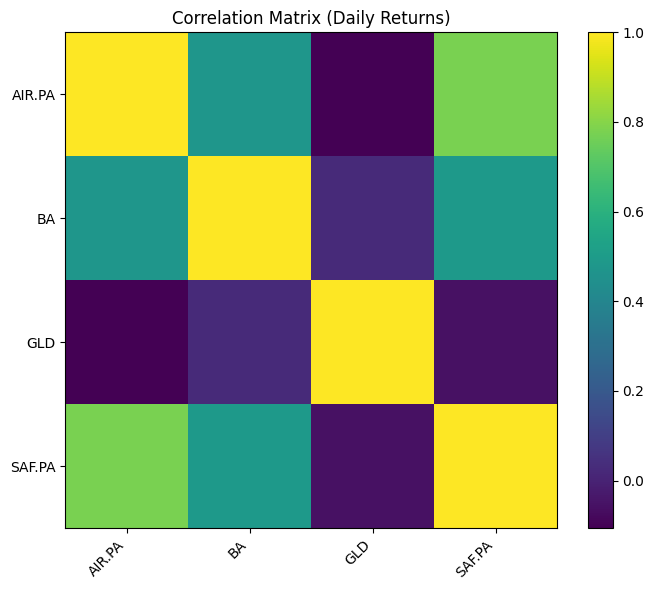

'figures/portfolio_correlation_matrix.png'

In [38]:
corr = returns.corr()

plt.figure(figsize=(7, 6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation Matrix (Daily Returns)")
plt.tight_layout()

fig_path_corr = os.path.join(FIG_DIR, "portfolio_correlation_matrix.png")
plt.savefig(fig_path_corr, dpi=300)
plt.show()

fig_path_corr

### 2.1 Sharpe-ratio optimization

In [39]:
def portfolio_performance(weights: np.ndarray, ret: pd.DataFrame, rf: float = 0.0):
    """Return (annualized_return, annualized_volatility, sharpe) for weights."""
    w = np.array(weights)
    port_return = np.sum(ret.mean() * w) * 252
    port_vol = np.sqrt(np.dot(w.T, np.dot(ret.cov() * 252, w)))
    sharpe = (port_return - rf) / port_vol if port_vol > 0 else np.nan
    return port_return, port_vol, sharpe

def negative_sharpe(weights: np.ndarray, ret: pd.DataFrame, rf: float = 0.0):
    return -portfolio_performance(weights, ret, rf)[2]

n = returns.shape[1]
x0 = np.ones(n) / n

constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
bounds = tuple((0.0, 1.0) for _ in range(n))

opt = minimize(negative_sharpe, x0=x0, args=(returns, 0.0), method="SLSQP",
               bounds=bounds, constraints=constraints)

opt_weights = pd.Series(opt.x, index=returns.columns, name="Weight")
opt_weights

Ticker
AIR.PA    0.079645
BA        0.060181
GLD       0.621145
SAF.PA    0.239028
Name: Weight, dtype: float64

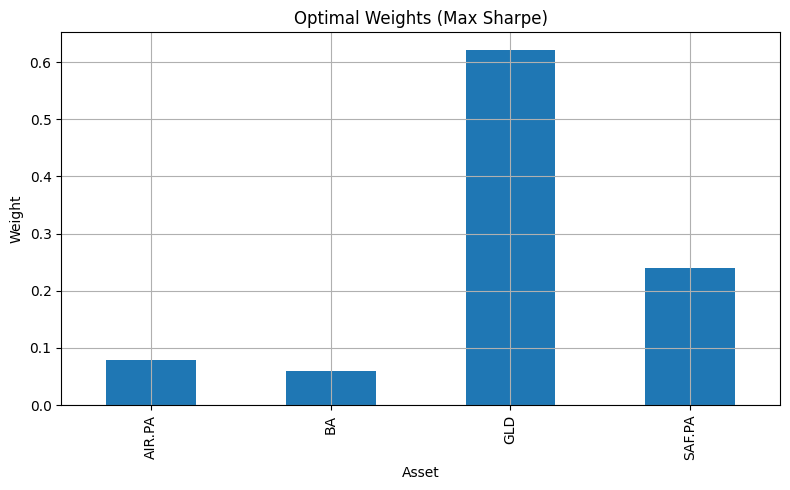

'figures/portfolio_optimal_weights.png'

In [40]:
plt.figure(figsize=(8, 5))
opt_weights.plot(kind="bar")
plt.title("Optimal Weights (Max Sharpe)")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.grid(True)

fig_path_weights = os.path.join(FIG_DIR, "portfolio_optimal_weights.png")
plt.tight_layout()
plt.savefig(fig_path_weights, dpi=300)
plt.show()

fig_path_weights

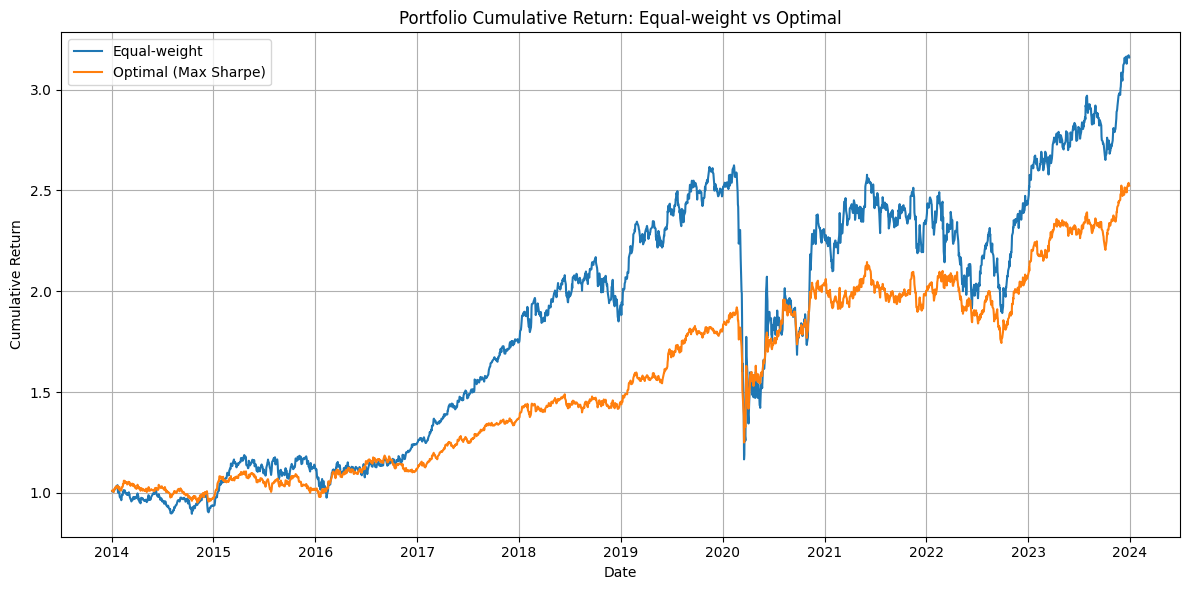

,AnnualizedReturn,AnnualizedVolatility,Sharpe
EqualWeight,0.142982,0.230377,0.620646
OptimalSharpe,0.103727,0.142208,0.729403


In [41]:
equal_w = np.ones(n) / n
eq_ret, eq_vol, eq_sharpe = portfolio_performance(equal_w, returns)
op_ret, op_vol, op_sharpe = portfolio_performance(opt.x, returns)

port_ret_equal = returns.dot(equal_w)
port_ret_opt   = returns.dot(opt.x)

cum_equal = (1 + port_ret_equal).cumprod()
cum_opt   = (1 + port_ret_opt).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_equal.index, cum_equal, label="Equal-weight")
plt.plot(cum_opt.index, cum_opt, label="Optimal (Max Sharpe)")
plt.title("Portfolio Cumulative Return: Equal-weight vs Optimal")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)

fig_path_compare = os.path.join(FIG_DIR, "portfolio_equal_vs_optimal.png")
plt.tight_layout()
plt.savefig(fig_path_compare, dpi=300)
plt.show()

summary = pd.DataFrame({
    "AnnualizedReturn": [eq_ret, op_ret],
    "AnnualizedVolatility": [eq_vol, op_vol],
    "Sharpe": [eq_sharpe, op_sharpe]
}, index=["EqualWeight", "OptimalSharpe"])

summary

In [42]:
# Save tables for LaTeX appendix if you want
metrics_path = os.path.join(FIG_DIR, "portfolio_asset_metrics.csv")
summary_path = os.path.join(FIG_DIR, "portfolio_portfolio_metrics.csv")

metrics.to_csv(metrics_path, index=True)
summary.to_csv(summary_path, index=True)

(metrics_path, summary_path)

('figures/portfolio_asset_metrics.csv',
 'figures/portfolio_portfolio_metrics.csv')